In [1]:
!pip install lightgbm

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [3]:
#Saving the latest copy which has all the data in to csv format
#train_gf.to_csv('train_gf.csv')
#import dask.dataframe as dd
elo_train=pd.read_csv('hist_df.csv')
#print('Number of data points : ', elo_train.shape[0])
print('Number of data points : ', elo_train.shape[0])
print('Number of features : ', elo_train.shape[1])
print('Features : ', elo_train.columns.values)
#train_data.head()

Number of data points :  8685556
Number of features :  20
Features :  ['Unnamed: 0' 'first_active_month' 'card_id' 'feature_1' 'feature_2'
 'feature_3' 'target' 'authorized_flag' 'city_id' 'category_1'
 'installments' 'category_3' 'merchant_category_id' 'merchant_id'
 'month_lag' 'purchase_amount' 'purchase_date' 'category_2' 'state_id'
 'subsector_id']


In [4]:
#Removing 'unnamed' column from dataframe
#https://stackoverflow.com/questions/43983622/remove-unnamed-columns-in-pandas-dataframe
elo_train = elo_train.loc[:, ~elo_train.columns.str.contains('^Unnamed')]
print('Number of features : ', elo_train.shape[1])

Number of features :  19


-first active month seems like not important as it doesn't contribute much to the transaction.

-authorised flag seems not important in deciding the feature almost majority of transactions are 'approved'

In [5]:
del elo_train['authorized_flag']
del elo_train['first_active_month']

In [6]:
print('Number of features : ', elo_train.shape[1])

Number of features :  17


In [7]:
elo_train.to_csv("elo_train.csv")

<h3> Train Test split </h3>

In [3]:
p_d=pd.read_csv('elo_train.csv')
#print('Number of data points : ', elo_train.shape[0])
print('Number of data points : ', p_d.shape[0])
print('Number of features : ', p_d.shape[1])
print('Features : ', p_d.columns.values)

Number of data points :  8685556
Number of features :  18
Features :  ['Unnamed: 0' 'card_id' 'feature_1' 'feature_2' 'feature_3' 'target'
 'city_id' 'category_1' 'installments' 'category_3' 'merchant_category_id'
 'merchant_id' 'month_lag' 'purchase_amount' 'purchase_date' 'category_2'
 'state_id' 'subsector_id']


In [4]:
#Removing 'unnamed' column from dataframe
#https://stackoverflow.com/questions/43983622/remove-unnamed-columns-in-pandas-dataframe
p_d = p_d.loc[:, ~p_d.columns.str.contains('^Unnamed')]
print('Number of features : ', p_d.shape[1])

Number of features :  17


In [5]:
from sklearn.utils import resample
elo_trn = resample(p_d,n_samples = 400000)

In [6]:
elo_trn.shape

(400000, 17)

In [7]:
#https://stackoverflow.com/questions/40531255/how-to-replace-empty-cells-with-0-and-change-strings-to-integers-where-possible/40531388
def recode_empty_cells(dataframe, list_of_columns):

    for column in list_of_columns:
      dataframe[column] = dataframe[column].replace(r'\s+', np.nan, regex=True)
      dataframe[column] = dataframe[column].fillna(0)

    return dataframe

In [8]:
recode_empty_cells(elo_trn, list(elo_trn.columns.values))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,card_id,feature_1,feature_2,feature_3,target,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
1680165,C_ID_6e40c6d1d7,4.0,1.0,0.0,0.790527,14.0,N,1.0,B,842.0,M_ID_1521aef9ea,-1.0,-0.695066,0.0,5.0,20.0,37.0
3145610,C_ID_7889b6f868,3.0,1.0,1.0,-0.902832,-1.0,Y,1.0,B,879.0,M_ID_9139332ccc,-3.0,-0.732648,0.0,5.0,-1.0,29.0
693405,C_ID_9fac55761f,2.0,3.0,0.0,-1.042969,19.0,N,1.0,B,507.0,M_ID_eb93ccf381,0.0,-0.220980,0.0,1.0,9.0,14.0
8682929,C_ID_35bf19ef29,0.0,0.0,0.0,0.000000,-1.0,Y,3.0,C,210.0,M_ID_621c8f4f75,1.0,-0.546387,0.0,1.0,-1.0,35.0
2487093,C_ID_e8ad14c005,2.0,1.0,0.0,0.394287,256.0,N,1.0,B,560.0,M_ID_dc963337c3,-5.0,-0.734361,0.0,5.0,5.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2171045,C_ID_36347cd128,2.0,1.0,0.0,-0.371338,199.0,N,1.0,B,307.0,M_ID_e061c72d34,-2.0,-0.664262,0.0,4.0,14.0,19.0
767202,C_ID_b706dae817,5.0,1.0,1.0,1.161133,150.0,N,1.0,B,705.0,M_ID_1a5880eb9a,-2.0,-0.660010,0.0,5.0,5.0,33.0
5066186,C_ID_ead4c6a1c7,5.0,1.0,1.0,-0.263916,-1.0,Y,1.0,B,879.0,M_ID_9139332ccc,-3.0,-0.721513,0.0,1.0,-1.0,29.0
3816591,C_ID_e11116d6d1,2.0,3.0,0.0,-0.875000,233.0,N,1.0,B,367.0,M_ID_a3aa808eb3,-8.0,-0.705405,0.0,1.0,9.0,16.0


In [9]:
#https://thispointer.com/pandas-change-data-type-of-single-or-multiple-columns-of-dataframe-in-python/
elo_trn['merchant_category_id']=elo_trn['merchant_category_id'].astype('int16')
elo_trn['feature_1']=elo_trn['feature_1'].astype('int16')
elo_trn['feature_2']=elo_trn['feature_2'].astype('int16')
elo_trn['feature_3']=elo_trn['feature_3'].astype('int16')
#elo_trn['authorized_flag']=elo_trn['authorized_flag'].astype('int16')
elo_trn['installments']=elo_trn['installments'].astype('int16')
#elo_trn['category_3']=elo_trn['category_3'].astype('float32')
#elo_trn['category_2']=elo_trn['category_2'].astype('float32')
# Convert first_active_month to datetime
#p_d['first_active_month'] = pd.to_datetime(p_d['first_active_month'],
                                             #format='%Y-%m')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [10]:
y = elo_trn["target"].values
X = elo_trn.drop("target",axis = 1)

In [11]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=85)

In [12]:
X_train.head(3)

,card_id,feature_1,feature_2,feature_3,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
1950195,C_ID_82d92e06f8,5,1,1,223.0,N,1,B,307,M_ID_7ebbaa4a05,-5.0,-0.697726,0.0,5.0,21.0,19.0
2009749,C_ID_4f500e4e9e,4,2,0,19.0,N,1,B,307,M_ID_f73a3fbf30,-4.0,-0.716855,0.0,1.0,9.0,19.0
1076201,C_ID_9f6052e4bb,2,2,0,251.0,N,1,B,813,M_ID_89d619dfd3,-5.0,-0.702955,0.0,3.0,8.0,29.0


<h3> Root Mean Square Error </h3>

We'll be using the root mean squared error as our evaluation metric:

$$
RMSE(y, \hat{y}) = \sqrt{ \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2 }
$$


In [13]:
def root_mean_squared_error(y_true, y_pred):
    """Root mean squared error regression loss"""
    return np.sqrt(np.mean(np.square(y_true-y_pred)))

In [14]:
root_mean_squared_error(np.mean(y_train), y_train)

1.2788985542843374

OK, so our models should for sure be getting RMSE values lower than 1.28

We have also checked with 8 million data points and found out that more or less both the RMSE looks same.

So, we condidering with 4 Million data points for better computation.

 To apply model on top of it ... 
Let us convert all the features either in to Numerical

In [95]:
elo_trn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 700654 to 91880
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   card_id               400000 non-null  object 
 1   feature_1             400000 non-null  int16  
 2   feature_2             400000 non-null  int16  
 3   feature_3             400000 non-null  int16  
 4   target                400000 non-null  float64
 5   city_id               400000 non-null  float64
 6   category_1            400000 non-null  float64
 7   installments          400000 non-null  int16  
 8   category_3            400000 non-null  float32
 9   merchant_category_id  400000 non-null  int16  
 10  merchant_id           400000 non-null  object 
 11  month_lag             400000 non-null  float64
 12  purchase_amount       400000 non-null  float64
 13  purchase_date         400000 non-null  float64
 14  category_2            400000 non-null  float32
 

Most of the datatypes to be changed accordingly to the problem.
Since, we are converting the most of the featureds 

first active month needs to be converted in to Numerical.


'card_id' needs to be converted in to Numerical.


<h3> Data pre-processing </h3>

The 'card_id's always start with C_ID_.

In [15]:
#https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes
elo_trn['card_id'].apply(len).unique()

array([15])

In [16]:
#https://www.geeksforgeeks.org/python-pandas-series-str-slice/
elo_trn['card_id'].str.slice(5, 15).sample(10)

239539     0e04880b40
7747528    35a963b6a2
4943362    5d363b9bcf
6327733    91e8e78f76
2796519    50efa6942b
4921010    182ce31cf6
6568441    6cd9169601
4918952    a2ebd032e7
533326     b16d7133af
6877993    276c915fb2
Name: card_id, dtype: object

Since, C_ID_ is a common part for all the line items in card_id, we are removing it just because it is not necessary to be retained in the model.

-if we remove the C_ID_ part from the card_id almost the remaining set of numbers looks in the range of 0-9,a-f.


In [17]:
(elo_trn['card_id']
 .str.slice(5, 15)
 .apply(lambda x: all(f in '0123456789abcdef' for f in x))
 .all())

True

In [18]:
#https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes
card_id_map = dict(zip(
    elo_trn['card_id'].values,
    elo_trn['card_id'].astype('category').cat.codes.values
))

In [19]:
# Map the values
elo_trn['card_id'] = elo_trn['card_id'].map(card_id_map).astype('uint32')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
# Map the values
X_train['card_id'] = X_train['card_id'].map(card_id_map).astype('uint32')
X_test['card_id'] = X_test['card_id'].map(card_id_map).astype('uint32')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Now, converting 'Merchant_id' in the same way as 'card_id'


The 'merchant_id' always start with M_ID_.

In [21]:
#https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes
elo_trn['merchant_id'].apply(len).unique()

array([15])

In [22]:
#https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes
merchant_id_map = dict(zip(
    elo_trn['merchant_id'].values,
    elo_trn['merchant_id'].astype('category').cat.codes.values
))

In [23]:
# Map the values
elo_trn['merchant_id'] = elo_trn['merchant_id'].map(merchant_id_map).astype('uint32')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
# Map the values
X_train['merchant_id'] = X_train['merchant_id'].map(merchant_id_map).astype('uint32')
X_test['merchant_id'] = X_test['merchant_id'].map(merchant_id_map).astype('uint32')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
elo_trn.head()

,card_id,feature_1,feature_2,feature_3,target,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
1680165,39413,4,1,0,0.790527,14.0,N,1,B,842,7584,-1.0,-0.695066,0.0,5.0,20.0,37.0
3145610,43022,3,1,1,-0.902832,-1.0,Y,1,B,879,51385,-3.0,-0.732648,0.0,5.0,-1.0,29.0
693405,56963,2,3,0,-1.042969,19.0,N,1,B,507,82994,0.0,-0.220980,0.0,1.0,9.0,14.0
8682929,19303,0,0,0,0.000000,-1.0,Y,3,C,210,34713,1.0,-0.546387,0.0,1.0,-1.0,35.0
2487093,82755,2,1,0,0.394287,256.0,N,1,B,560,77736,-5.0,-0.734361,0.0,5.0,5.0,34.0


In [26]:
X_train.head()

,card_id,feature_1,feature_2,feature_3,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
1950195,46674,5,1,1,223.0,N,1,B,307,44809,-5.0,-0.697726,0.0,5.0,21.0,19.0
2009749,28476,4,2,0,19.0,N,1,B,307,87061,-4.0,-0.716855,0.0,1.0,9.0,19.0
1076201,56851,2,2,0,251.0,N,1,B,813,48736,-5.0,-0.702955,0.0,3.0,8.0,29.0
882404,82193,2,1,0,12.0,N,1,B,360,51763,-5.0,-0.716479,0.0,5.0,5.0,34.0
4827284,14255,4,1,0,283.0,N,1,B,884,75568,-1.0,-0.536837,0.0,1.0,9.0,27.0


<h3> Converting Boolean in to Numerical </h3>

In [27]:
#converting boolean features in to Numerical
#https://datascience.stackexchange.com/questions/42465/do-i-need-to-convert-booleans-to-ints-to-enter-them-in-a-machine-learning-algori
#hist_f['authorized_flag'] = hist_f['authorized_flag'].map({'Y': 1, 'N': 0})
elo_trn['category_1'] = elo_trn['category_1'].map({'Y': 1, 'N': 0})
X_train['category_1'] = X_train['category_1'].map({'Y': 1, 'N': 0})
X_test['category_1'] = X_test['category_1'].map({'Y': 1, 'N': 0})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [28]:
#converting boolean features in to Numerical
#https://datascience.stackexchange.com/questions/42465/do-i-need-to-convert-booleans-to-ints-to-enter-them-in-a-machine-learning-algori
#hist_f['authorized_flag'] = hist_f['authorized_flag'].map({'Y': 1, 'N': 0})
elo_trn['category_3'] = elo_trn['category_3'].map({'A':0, 'B':1, 'C':2})
X_train['category_3'] = X_train['category_3'].map({'A':0, 'B':1, 'C':2})
X_test['category_3'] = X_test['category_3'].map({'A':0, 'B':1, 'C':2})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

<h2> Applying Machine Learning models </h2>

<h3> 1) Xbgoost Model </h3>

<h3> Hyperparameter Tuning </h3>

In [31]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb 
parameters2 = {'n_estimators': [5,10,50,100,200,500,1000] ,
             'max_depth' :  [2,3,4,5,6,7,8,9,10]}


XGB_rg = xgb.XGBRegressor(random_state=11,class_weight='balanced')

XGB_rg2=RandomizedSearchCV(XGB_rg ,param_distributions = parameters2, scoring="neg_mean_squared_error", cv=5)
XGB_rg2.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          class_weight='balanced',
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          mono...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validat

In [32]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
a2=XGB_rg2.best_params_['n_estimators']
p2 = XGB_rg2.best_params_['max_depth']
print(XGB_rg2.best_score_)
print(a2)
print(p2)

-1.2954496745193524
1000
6


In [33]:
#Calculating y_train_pred and y_test_pred
y_train_pred = XGB_rg2.predict(X_train)
y_test_pred = XGB_rg2.predict(X_test)

In [34]:
#Calculating rsme and mape scores by using the utility function
rmse_train = root_mean_squared_error(np.mean(y_train), y_train_pred)
rmse_test = root_mean_squared_error(np.mean(y_test), y_test_pred)

In [35]:
print('Train RMSE : ', rmse_train)
print('\n'+'-'*45)
print('Test RMSE : ', rmse_test)

Train RMSE :  0.57682365

---------------------------------------------
Test RMSE :  0.48889488


-There is a quite difference between Train and Test RMSE values, seems like an overfitting.

In [36]:
# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=a2, max_depth=p2)
first_xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=13, num_parallel_tree=1,
             objective='reg:squarederror', random_state=15, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=False, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

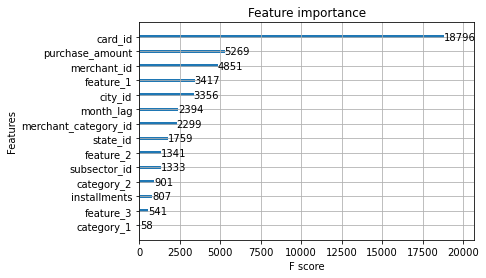

In [37]:
xgb.plot_importance(first_xgb)
plt.show()

<h3> 2) Random Forest </h3>

<h4> Hyperparameter Tuning </h4>

In [39]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.7/site-packages (0.22.2.post1)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


parameters = {'n_estimators': [5,10,50,100,200,500,1000] ,
             'max_depth' :  [2,3,4,5,6,7,8,9,10]}


clf_rf = RandomForestRegressor(random_state=11)

clf=RandomizedSearchCV(clf_rf ,param_distributions = parameters, scoring="neg_mean_squared_error", cv=10)
clf.fit(X_train,y_train)

In [30]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
a=clf.best_params_['n_estimators']
p = clf.best_params_['max_depth']
print(clf.best_score_)
print(a)
print(p)

-1.613220463986368
100
10


In [31]:
#Calculating y_train_pred and y_test_pred
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [32]:
#Calculating rsme and mape scores by using the utility function
rmse_train = root_mean_squared_error(np.mean(y_train), y_train_pred)
rmse_test = root_mean_squared_error(np.mean(y_test), y_test_pred)

In [33]:
print('Train RMSE : ', rmse_train)
print('\n'+'-'*45)
print('Test RMSE : ', rmse_test)

Train RMSE :  0.09853955273915958

---------------------------------------------
Test RMSE :  0.088096504311728


In [34]:
# initialize Our first XGBoost model...
first_rf=RandomForestRegressor(random_state=11,max_depth=p, n_estimators=a)
first_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=11, verbose=0, warm_start=False)

In [35]:
# display the relative importance of each attribute
importances = first_rf.feature_importances_
#Sort it
print ("Sorted Feature Importance:")
sorted_feature_importance = sorted(zip(importances, list(X_train)), reverse=True)
print (sorted_feature_importance)

Sorted Feature Importance:
[(0.34665109585490045, 'card_id'), (0.13576402615497096, 'purchase_amount'), (0.11408330014067478, 'merchant_id'), (0.07297851646716934, 'city_id'), (0.06315624630846088, 'merchant_category_id'), (0.05175112937741567, 'month_lag'), (0.04550159577712224, 'state_id'), (0.04330655716908893, 'subsector_id'), (0.03898770904210475, 'feature_1'), (0.02853309125031698, 'feature_2'), (0.021640896024411282, 'installments'), (0.020650079553432087, 'category_2'), (0.008067049901486534, 'feature_3'), (0.006164689892738173, 'category_1'), (0.002764017085706982, 'category_3'), (0.0, 'purchase_date')]


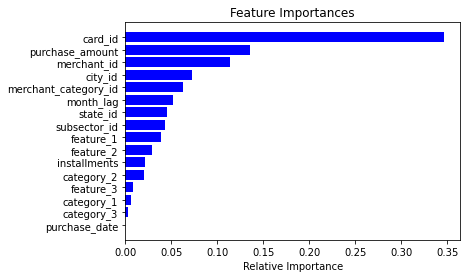

In [36]:
features = list(X_train)
importances = first_rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<h3> 3) LightGBM </h3>

<h4> Hyperparameter Tuning </h4>

In [29]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
param = {'n_estimators':  [5,10,50,100,200,500,1000] ,
             'max_depth' :  [2,3,4,5,6,7,8,9,10] ,
             'reg_lambda':  [0.05,0.5,0,1,2] ,
             'reg_alpha' :  [0.05,0.5,0,1,2] ,
             'learning_rate':  [0.005,0.05,0.5,0.1]}


estimator = lgb.LGBMRegressor()
clf= RandomizedSearchCV(estimator, param_distributions=param, scoring='neg_mean_squared_error', cv=5, verbose=1)
#clf.fit(X_train,y_train)
#clf.best_params_, clf.best_score_

In [30]:
clf.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(clf.best_score_, clf.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min finished


Best score reached: -1.6064828551920822 with params: {'reg_lambda': 1, 'reg_alpha': 0.05, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1} 


In [31]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
a=clf.best_params_['n_estimators']
p = clf.best_params_['max_depth']
q = clf.best_params_['reg_lambda']
r = clf.best_params_['reg_alpha']
s = clf.best_params_['learning_rate']
print(clf.best_score_)
print(a)
print(p)
print(q)
print(r)
print(s)

-1.6064828551920822
500
8
1
0.05
0.1


In [32]:
#Calculating y_train_pred and y_test_pred
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [33]:
#Calculating rsme and mape scores by using the utility function
rmse_train = root_mean_squared_error(np.mean(y_train), y_train_pred)
rmse_test = root_mean_squared_error(np.mean(y_test), y_test_pred)

In [34]:
print('Train RMSE : ', rmse_train)
print('\n'+'-'*45)
print('Test RMSE : ', rmse_test)

Train RMSE :  0.19503661136870817

---------------------------------------------
Test RMSE :  0.18523077930954995


In [35]:
# Train new model
first_LG = LGBMRegressor(max_depth=p, n_estimators=a, learning_rate = s, reg_lambda = q, reg_alpha = r, class_weight='balanced')
first_LG.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight='balanced',
              colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
              max_depth=8, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.05, reg_lambda=1,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [37]:
# display the relative importance of each attribute
importances = first_LG.feature_importances_
#Sort it
print ("Sorted Feature Importance:")
sorted_feature_importance = sorted(zip(importances, list(X_train)), reverse=True)
print (sorted_feature_importance)

Sorted Feature Importance:
[(3004, 'card_id'), (2174, 'purchase_amount'), (2008, 'merchant_id'), (1546, 'city_id'), (1231, 'month_lag'), (1077, 'merchant_category_id'), (904, 'subsector_id'), (785, 'state_id'), (674, 'feature_1'), (484, 'category_2'), (447, 'feature_2'), (418, 'installments'), (200, 'feature_3'), (47, 'category_1'), (1, 'category_3'), (0, 'purchase_date')]


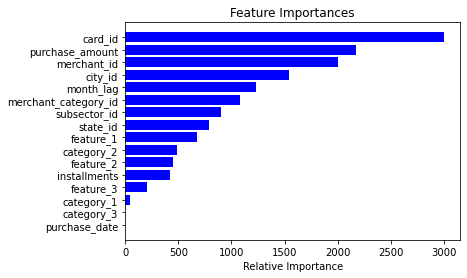

In [38]:
features = list(X_train)
importances = first_LG.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [37]:

from prettytable import PrettyTable

tb = PrettyTable()
tb.field_names= ("Model", "Test- MSE")
tb.add_row(["Randomised Model", "1.283"])
tb.add_row(["Random Forest", "0.088"])
tb.add_row(["XGBoost", "0.488",])
tb.add_row(["LightGBM", "0.185"])
print(tb.get_string(titles = "Regression Models- Observations"))
#print(tb)

+------------------+-----------+
|      Model       | Test- MSE |
+------------------+-----------+
| Randomised Model |   1.283   |
|  Random Forest   |   0.088   |
|     XGBoost      |   0.488   |
|     LightGBM     |   0.185   |
+------------------+-----------+
